In [20]:
from enum import Enum
import random
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import copy
import json
import pandas as pd
import csv
from abc import ABC, abstractmethod

In [21]:
# Directional Vectors
DY = [-1, 1, 0, 0]
DX = [0, 0, 1, -1]   

# Represents the different types of Cells
class Cell(Enum):
    BLOCKED = 0
    OPEN = 1
    FIRE = 2
    BUTTON = 3

    def __eq__(self, other):
        if isinstance(other, Cell):
            return self.value == other.value
        return self.value == other

In [22]:
# Putting this here because I think it could be an efficient architecture, basically skeleton code
class Bot(ABC):
    def __init__(self, board):
        self.board = board
        self.size = board.D
        self.position = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))

    @abstractmethod
    def action(self):
        """Placeholder method that requires all subclasses to override this method"""
        raise NotImplementedError()

class BotOne(Bot):
    def action(self):
        # Do stuff
        pass


In [23]:
# Represents the Ship
class Ship:
    def __init__(self, D = 50, k = 1, seed = None):
        self.actions = {}
        self.D = D
        self.k = k
        self.seed = seed
        self.board = []
        self.open_cells = []
        self.fire_cells = []
        self.bot_location = ()
        self.init_board()

    
    def init_board(self):
        """Initialize the 50x50 board following Project 1 Algorithm"""
        n = self.D
        random.seed(self.seed)
        
        self.board = [[Cell.BLOCKED for _ in range(n)] for _ in range(n)]
        rand_row = random.randint(0, n - 1)
        rand_col = random.randint(0, n - 1)
        
        self.board[rand_row][rand_col] = Cell.OPEN
        valid_cells = set()
        open_cells = [(rand_row, rand_col)]
        valid_cells.add((rand_row, rand_col))

        while True:
            candidates = self.get_candidates(valid_cells)
            if not candidates:
                break

            rand_cell = random.choice(candidates)
            r, c = rand_cell
            self.board[r][c] = Cell.OPEN
            valid_cells.add((r, c))
            open_cells.append((r, c))

        # Collect all open cells with exactly 1 open neighbor
        dead_ends = []
        for oc in open_cells:
            r, c = oc
            open_neighbors = self.get_neighbor_count(r, c, Cell.OPEN)
            if open_neighbors == 1:
                dead_ends.append(oc)

        # Open approximately half of the dead ends
        num_dead_ends = len(dead_ends)
        while len(dead_ends) > num_dead_ends // 2:

            # Pick a random dead end and open one of it's neighbors
            rand_idx = random.randint(0, len(dead_ends) - 1)
            r, c = dead_ends[rand_idx]
            closed_neighbors = self.get_neighbors(r, c, Cell.BLOCKED)
            if closed_neighbors:
                rand_cell = random.choice(closed_neighbors)
                nr, nc = rand_cell
                self.board[nr][nc] = Cell.OPEN
                open_cells.append((nr, nc))
                dead_ends.pop(rand_idx)

                # Check for newly opened dead ends
                open_neighbors = self.get_neighbors(nr, nc, Cell.OPEN)
                for neighbor in open_neighbors:
                    r, c = neighbor

                    # If this pair is also a dead end, remove it
                    try:
                        idx = dead_ends.index((r, c))
                        dead_ends.pop(idx)
                    except ValueError: # was not a dead end
                        continue
                        
        self.open_cells = open_cells
        
    # Helper Methods
    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D

    def get_neighbors(self, r, c, target):
        """Get all of the valid neighbors of the desired type"""
        res = []
        for i in range(4):
            nr = DY[i] + r
            nc = DX[i] + c
            if self.is_valid(nr, nc) and self.board[nr][nc] == target:
                res.append((nr, nc))
        
        return res

    def get_neighbor_count(self, r, c, target):
        """Get the number of valid neighbors of the desired type"""
        return len(self.get_neighbors(r, c, target))

    def get_candidates(self, open_cells):
        n = self.D
        candidates = []
        to_remove = []
        for pair in open_cells:
            r, c = pair
            closed_neighbors = self.get_neighbors(r, c,  Cell.BLOCKED)
            valid_found = 0
            for neighbor in closed_neighbors:
                n_r, n_c = neighbor
                open_neighbors = self.get_neighbor_count(n_r, n_c, Cell.OPEN)
                if open_neighbors == 1:
                    valid_found += 1
                    candidates.append((n_r, n_c))

            if valid_found == 0:
                # print("removing {}".format(pair))
                to_remove.append(pair) 

        for pair in to_remove:
            open_cells.remove(pair)
            
        return candidates

    def display(self, path = None):
        """Display a grid image of the current board (FOR USE IN NOTEBOOK)"""
        n = self.D
        copy_board = [row[:] for row in self.board]
        if not isinstance(copy_board[0][0], (float, int)):
            for i in range(n):
                for j in range(n):
                    copy_board[i][j] = copy_board[i][j].value

        if path:
            for pair in path:
                r, c = pair
                copy_board[r][c] = 3
                
        image_data = np.array(copy_board)
        plt.imshow(image_data, "Blues")
        # plt.axis("off")
        plt.show()
        

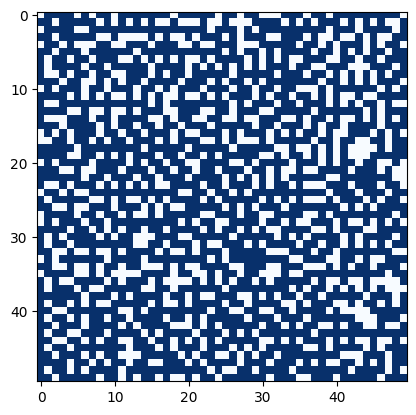

In [24]:
s = Ship()
s.display()

b = BotOne(s)
b